# Training a NN with Urban Sound Challenge Data

**Background:**

In parallel to the actuall fall detection experiment, we'll train a neural network leveraging the urban challenge dataset in order to develop the necessary libraries to map wav files to features (either MFCC or spectogram) and baseline the performance of the different approaches)

## Dataset

In [136]:
import matplotlib.pyplot as plt
from python_speech_features import mfcc
import pandas as pd
import os
import numpy as np
import soundfile
from scipy import signal

In [14]:
URBAN_SOUND_DIR = "/media/nvidia/ROMULO'S/urban_sound_challenge/"

## Load sample WAV File

In [150]:
samples, sample_rate = soundfile.read(URBAN_SOUND_DIR+"Train/5132.wav")
#sample_rate, samples = wavfile.read("./tests/wav/hello.wav")

In [174]:
mfcc_feat = mfcc(samples,sample_rate,nfft=2400)

In [175]:
mfcc_feat.shape

(68, 13)

In [164]:
pad = np.zeros((801,13))

In [177]:
pad[:68,:] = mfcc_feat

In [178]:
pad

array([[ -9.1441938 ,  -3.7632499 ,  -1.58394464, ...,   2.45133493,
         11.56578424,  -2.23603561],
       [ -6.92836361,  -0.13577445,  -8.33232622, ...,  -8.78324648,
         11.56998245,  -4.48411414],
       [ -4.26740706,  -0.1535467 , -14.60630514, ..., -17.6728315 ,
          8.79206335,   3.03339257],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [153]:
f, t, spectrogram= signal.spectrogram(samples,sample_rate)

In [157]:
a = np.array([[1,2,3], [4,5,6]])

In [163]:
c[:len(b)] += b

ValueError: operands could not be broadcast together with shapes (3,) (4,) 

In [161]:
np.reshape(a, (4,4))

ValueError: cannot reshape array of size 6 into shape (4,4)

In [154]:
spectrogram.shape

(16573, 2, 1)

ValueError: too many values to unpack (expected 2)

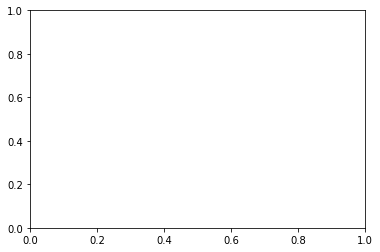

In [138]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Loading the dataset

In [221]:
train_df = pd.read_csv(URBAN_SOUND_DIR+'train.csv')
test_df = pd.read_csv(URBAN_SOUND_DIR+'test.csv')

In [226]:
def parser(row):
    # fun
    #ction to load files and extract features
    folder = 'Train'
    file_name = os.path.join(URBAN_SOUND_DIR, folder, str(row.ID) + '.wav')
   # handle exception to check if there isn't a file which is corrupted
    try:
        samples, sample_rate = soundfile.read(file_name)
        # here kaiser_fast is a technique used for faster extraction
        mfcc_feat = mfcc(samples,sample_rate,nfft=2400)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return pd.Series([None, None])
    return pd.Series([mfcc_feat, row.Class])

In [227]:
def parser_test(row):
    # fun
    #ction to load files and extract features
    folder = 'Test'
    file_name = os.path.join(URBAN_SOUND_DIR, folder, str(row.ID) + '.wav')
   # handle exception to check if there isn't a file which is corrupted
    try:
        samples, sample_rate = soundfile.read(file_name)
        # here kaiser_fast is a technique used for faster extraction
        mfcc_feat = mfcc(samples,sample_rate,nfft=2400)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return pd.Series([None, None])
    return pd.Series([mfcc_feat])

In [95]:
temp = train_df.apply(parser, axis=1)
temp.columns = ['feature', 'label']

In [228]:
test_temp = test_df.apply(parser_test, axis=1)
test_temp.columns = ['feature']

KeyboardInterrupt: 

In [96]:
temp.dropna(inplace=True)

In [97]:
temp.shape

(5435, 2)

In [100]:
classes = list(temp['label'].unique())

In [103]:
temp['label_encoded'] = temp['label'].apply(classes.index)

In [179]:
X = []
for x in temp.feature.tolist():
    pad = np.zeros((801,13))
    pad[:x.shape[0],:] = x
    X.append(pad)

In [203]:
X_avg = []
for x in temp.feature.tolist():
    X_avg.append(np.mean(x,axis=0))

In [193]:
X_avg[0].shape

(13,)

In [202]:
X_avg_t = []
for x in temp.feature.tolist():
    pad = np.zeros((801,))
    pad[:x.shape[0]] = np.mean(x.T,axis=0)
    X_avg_t.append(pad)

In [204]:
X_avg_t[0].shape

(801,)

In [210]:
X = np.array(X_avg)
y = np.array(temp.label_encoded.tolist())

In [211]:
set([x.shape for x in X])

{(13,)}

# Setting up a simple model

In [105]:
import tensorflow as tf
from tensorflow import keras

In [212]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(13,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(60, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [218]:
model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [219]:
model.fit(X, y, epochs=10,batch_size=10,shuffle=False)

Epoch 1/10
5435/5435 [==============================] - 14s 3ms/step - loss: 0.3097 - acc: 0.8999
Epoch 2/10
5435/5435 [==============================] - 13s 2ms/step - loss: 0.2766 - acc: 0.9121
Epoch 3/10
5435/5435 [==============================] - 13s 2ms/step - loss: 0.2445 - acc: 0.9249
Epoch 4/10
5435/5435 [==============================] - 13s 2ms/step - loss: 0.2274 - acc: 0.9305
Epoch 5/10
5435/5435 [==============================] - 13s 2ms/step - loss: 0.2099 - acc: 0.9314
Epoch 6/10
5435/5435 [==============================] - 13s 2ms/step - loss: 0.1987 - acc: 0.9354
Epoch 7/10
5435/5435 [==============================] - 13s 2ms/step - loss: 0.1817 - acc: 0.9439
Epoch 8/10
5435/5435 [==============================] - 13s 2ms/step - loss: 0.1650 - acc: 0.9509
Epoch 9/10
5435/5435 [==============================] - 13s 2ms/step - loss: 0.1584 - acc: 0.9511
Epoch 10/10
5435/5435 [==============================] - 13s 2ms/step - loss: 0.1463 - acc: 0.9580


# Simple model using spectrograms

In [229]:
def parser_spec(row):
    # fun
    #ction to load files and extract features
    folder = 'Train'
    file_name = os.path.join(URBAN_SOUND_DIR, folder, str(row.ID) + '.wav')
   # handle exception to check if there isn't a file which is corrupted
    try:
        samples, sample_rate = soundfile.read(file_name)
        # here kaiser_fast is a technique used for faster extraction
        f, t, spectrogram= signal.spectrogram(samples,sample_rate)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return pd.Series([None, None])
    return pd.Series([spectrogram, row.Class])

In [ ]:
temp_spec = train_df.apply(parser_spec, axis=1)
temp_spec.columns = ['feature', 'label']